In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"ordustephen","key":"3b804872cd25495419d918e156a842b4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d suchintikasarkar/sentiment-analysis-for-mental-health
!unzip sentiment-analysis-for-mental-health.zip

Dataset URL: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health
License(s): DbCL-1.0
sentiment-analysis-for-mental-health.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sentiment-analysis-for-mental-health.zip
replace Combined Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization (for EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Label Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#  Transformers & Tokenization
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

# Torch (backend for Transformers)
import torch

#  Utility
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_csv("Combined Data.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.shape

(53043, 3)

In [ ]:
missing = df.isnull().sum()
missing

,0
Unnamed: 0,0
statement,362
status,0


In [ ]:
df.columns.tolist()

['Unnamed: 0', 'statement', 'status']

In [ ]:
df = df.dropna(subset=['statement']).reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df.columns = ['text', 'label']

In [ ]:
df.head()

,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


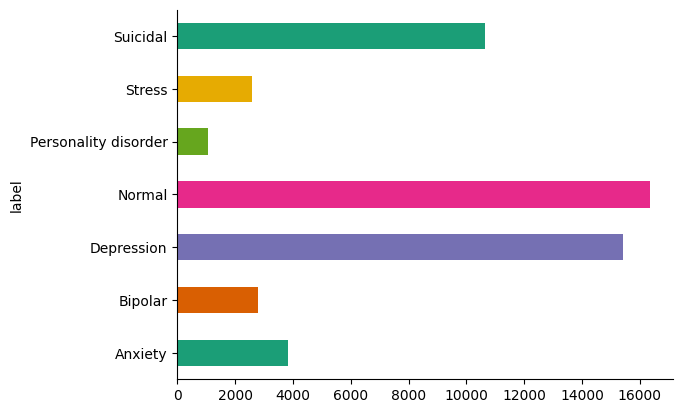

In [ ]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df["label"].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Lowercase and strip whitespace
df['label'] = df['label'].str.strip().str.lower()

# Encode labels
le = LabelEncoder()
df['label_id'] = le.fit_transform(df['label'])

# Save label mapping for later use
label2id = dict(zip(le.classes_, le.transform(le.classes_)))
id2label = {v: k for k, v in label2id.items()}

print("Label mapping:", label2id)


Label mapping: {'anxiety': np.int64(0), 'bipolar': np.int64(1), 'depression': np.int64(2), 'normal': np.int64(3), 'personality disorder': np.int64(4), 'stress': np.int64(5), 'suicidal': np.int64(6)}


In [ ]:
df.head()

,text,label,label_id
0,oh my gosh,anxiety,0
1,"trouble sleeping, confused mind, restless hear...",anxiety,0
2,"All wrong, back off dear, forward doubt. Stay ...",anxiety,0
3,I've shifted my focus to something else but I'...,anxiety,0
4,"I'm restless and restless, it's been a month n...",anxiety,0


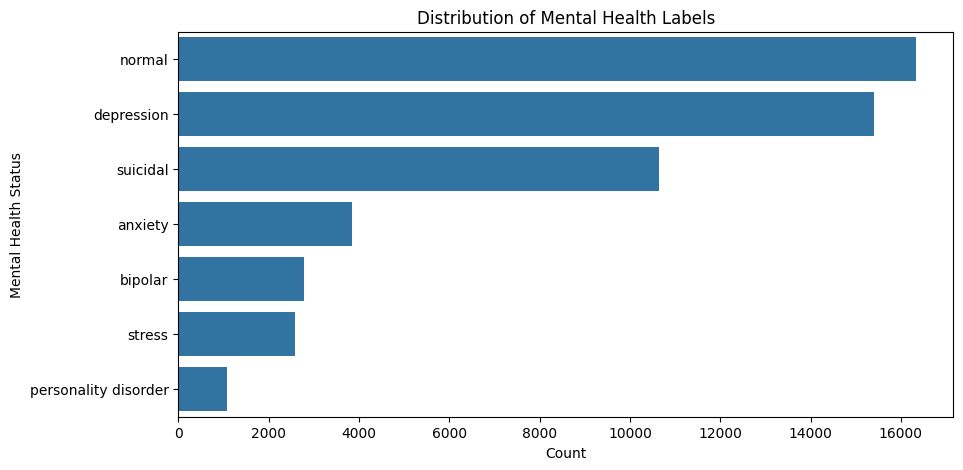

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(y=df['label'], order=df['label'].value_counts().index)
plt.title("Distribution of Mental Health Labels")
plt.xlabel("Count")
plt.ylabel("Mental Health Status")
plt.show()


In [ ]:
label_counts = df['label'].value_counts()
print(label_counts)

label
normal                  16343
depression              15404
suicidal                10652
anxiety                  3841
bipolar                  2777
stress                   2587
personality disorder     1077
Name: count, dtype: int64


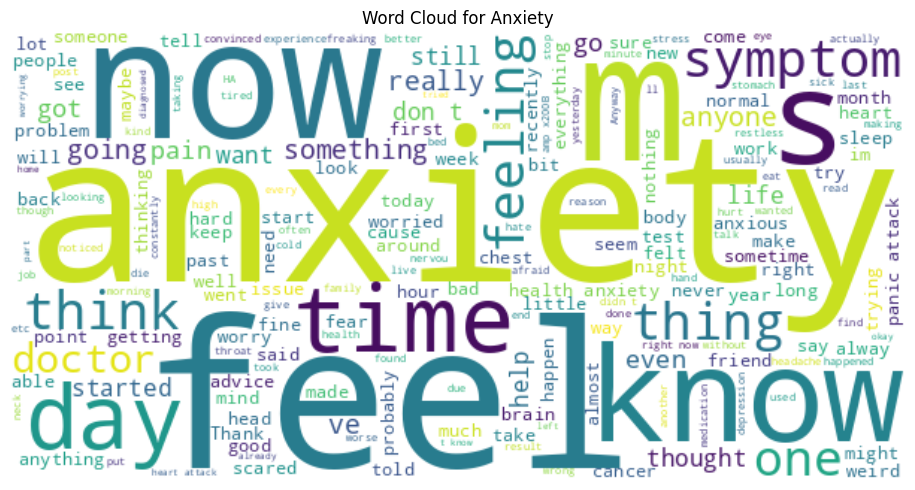

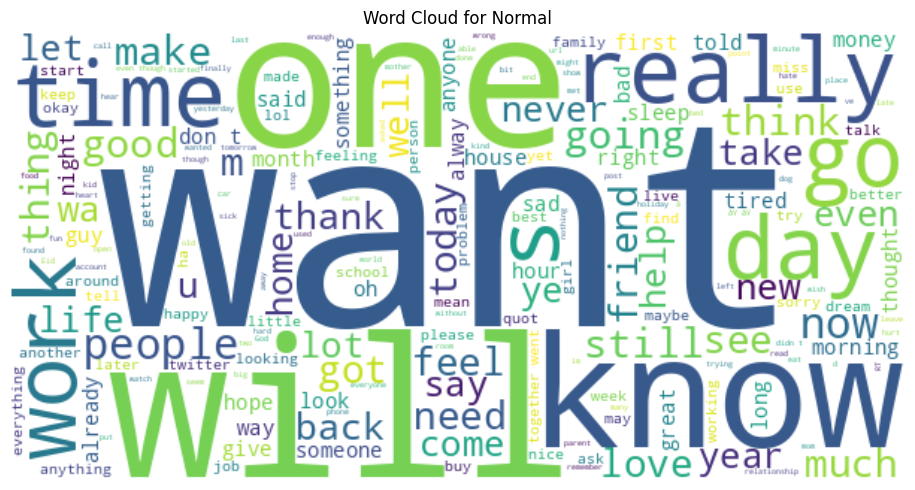

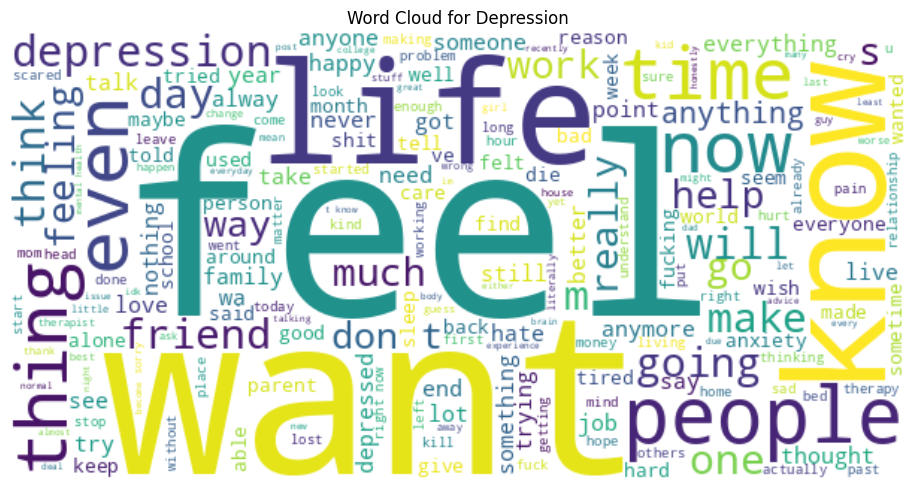

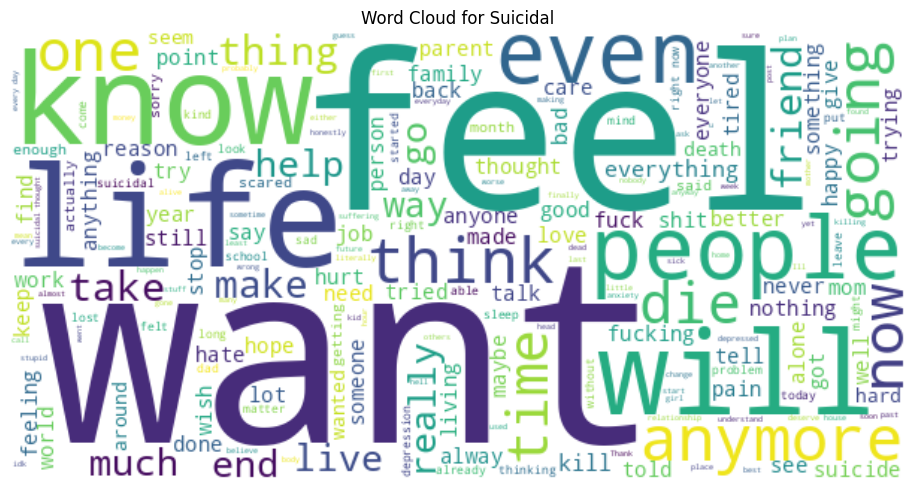

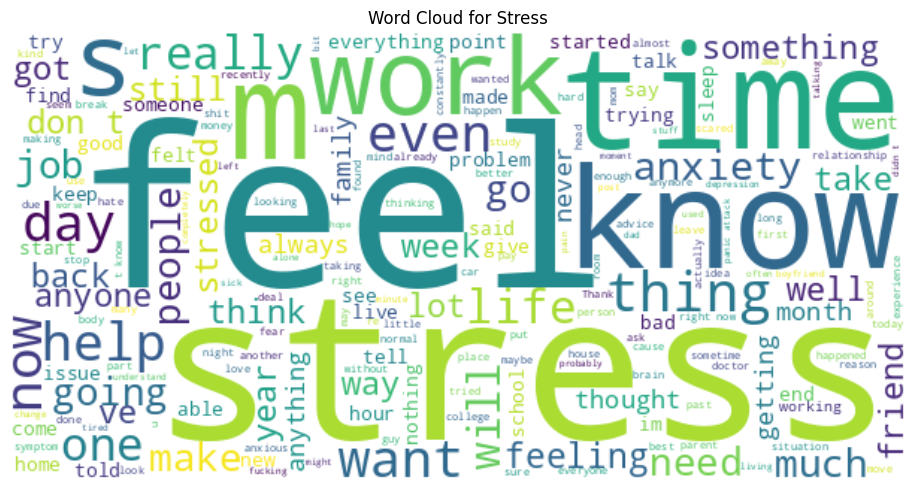

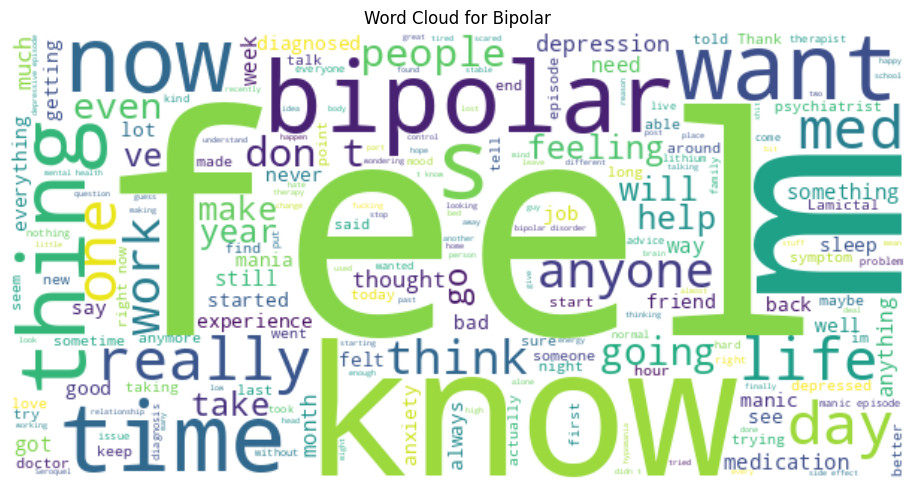

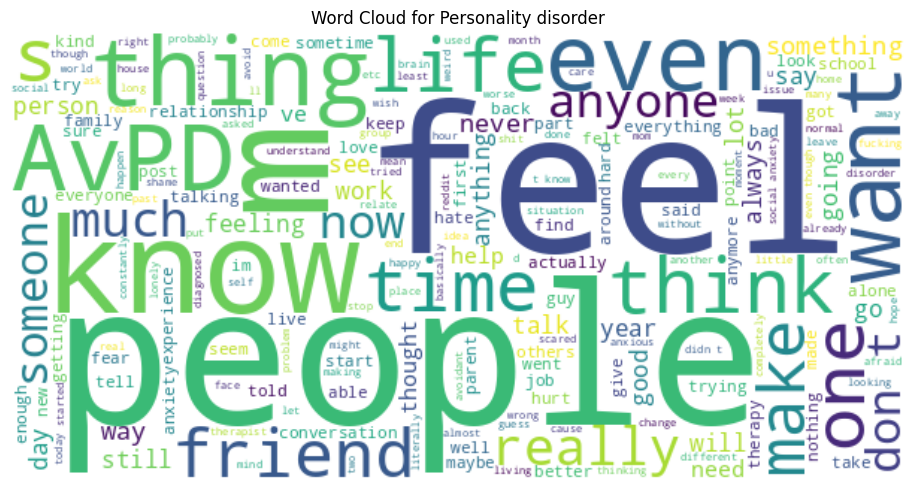

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for label in df['label'].unique():
    text = " ".join(df[df['label'] == label]['text'].astype(str))
    wordcloud = WordCloud(width=600, height=300, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {label.capitalize()}")
    plt.tight_layout()
    plt.show()


In [ ]:
# Cleaning & Preprocessing

In [ ]:
import spacy
import re

In [ ]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

In [ ]:
def clean_text(text):
    if pd.isnull(text):
        return ""

    # Lowercase and remove URLs, mentions, hashtags, special characters
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\S+|#\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)

    # Process with spaCy
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)


In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
print(df[['text', 'clean_text']].sample(5))

                                                    text  \
49398  Yup. Done. Literally never been so fucked up i...   
22608    i could not. WHY? i want out. I am such a pussy   
8817   Knowing that if it does not kill me and I cann...   
5980                                   Not really good ”   
8594   I feel like killing myself. just had one of th...   

                                              clean_text  
49398  yup literally fuck year treatment med honestly...  
22608                                         want pussy  
8817   know kill quiet stomach pain ill probably leav...  
5980                                                good  
8594                         feel like kill bad day life  


In [ ]:
df_final = df[['clean_text', 'label_id']]

In [ ]:
df["clean_text"][1]

'trouble sleep confused mind restless heart tune'

In [ ]:
df["text"][1]

'trouble sleeping, confused mind, restless heart. All out of tune'

In [ ]:
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
X = df_final['clean_text']
y = df_final['label_id']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# Reduce dimensionality
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_svd, y_train)

In [ ]:
# Training baseline model
l_model = LogisticRegression(max_iter=1000, class_weight='balanced')
l_model.fit(X_resampled, y_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
y_pred = l_model.predict(X_test_svd)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74       768
           1       0.67      0.78      0.72       556
           2       0.77      0.59      0.67      3081
           3       0.89      0.80      0.84      3269
           4       0.26      0.69      0.38       215
           5       0.39      0.59      0.47       517
           6       0.63      0.72      0.67      2131

    accuracy                           0.71     10537
   macro avg       0.62      0.71      0.64     10537
weighted avg       0.74      0.71      0.72     10537



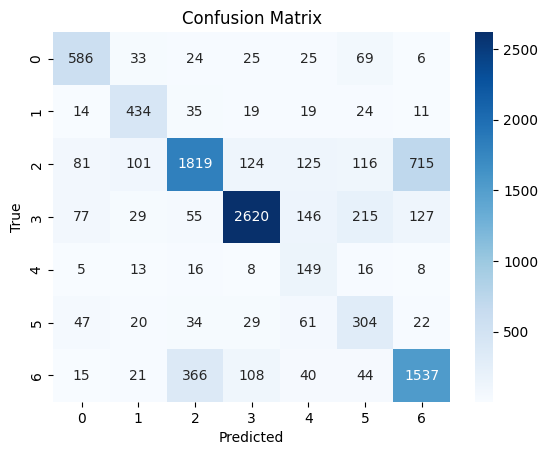

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
text = [
    "I feel fine and content with my life lately.",
    "I can't stop worrying even when there's nothing wrong.",
    "Sometimes I think the world would be better without me.",
    "I don’t see the point in anything anymore.",
    "People tell me I act like different persons at different times.",
    "I enjoy my job and feel balanced emotionally.",
    "My mood constantly shifts without any clear reason.",
    "I'm having trouble handling stress at work.",
    "I feel like no one really understands who I am.",
    "I’ve been feeling empty and hopeless lately.",
    "My emotions swing from joy to sadness in minutes.",
    "I can't sleep and my mind won't stop racing.",
    "I often feel overwhelmed and burned out.",
    "Life doesn’t feel worth living these days.",
    "Most days I just feel okay, nothing special.",
]

In [ ]:
texts = tfidf.transform(text)
texts = svd.transform(texts)

In [ ]:
# Step 2: Predict
preds = l_model.predict(texts)

In [ ]:
preds[0], preds[1]

(np.int64(0), np.int64(3))

In [ ]:
# Step 3: Map predictions back to label names
id_to_label = {
    0: "anxiety",
    1: "bipolar",
    2: "depression",
    3: "normal",
    4: "personality disorder",
    5: "stress",
    6: "suicidal"
}

# Step 4: Display
for t, pred in zip(text, preds):
    print(f"{t}: {id_to_label[pred]}")

I feel fine and content with my life lately.: anxiety
I can't stop worrying even when there's nothing wrong.: normal
Sometimes I think the world would be better without me.: normal
I don’t see the point in anything anymore.: depression
People tell me I act like different persons at different times.: normal
I enjoy my job and feel balanced emotionally.: stress
My mood constantly shifts without any clear reason.: bipolar
I'm having trouble handling stress at work.: stress
I feel like no one really understands who I am.: bipolar
I’ve been feeling empty and hopeless lately.: stress
My emotions swing from joy to sadness in minutes.: normal
I can't sleep and my mind won't stop racing.: stress
I often feel overwhelmed and burned out.: stress
Life doesn’t feel worth living these days.: depression
Most days I just feel okay, nothing special.: normal


In [ ]:
# Transformer Upgrade

In [ ]:
df.head()

,text,label,label_id,clean_text
0,oh my gosh,anxiety,0,oh gosh
1,"trouble sleeping, confused mind, restless hear...",anxiety,0,trouble sleep confused mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",anxiety,0,wrong dear forward doubt stay restless restles...
3,I've shifted my focus to something else but I'...,anxiety,0,ve shift focus m worried
4,"I'm restless and restless, it's been a month n...",anxiety,0,m restless restless month boy mean


In [ ]:
df_short = df.sample(n=30100, random_state=42)
df_short.shape

(30100, 4)

In [ ]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_short, test_size=0.2, stratify=df_short['label_id'], random_state=42)
train_dataset = Dataset.from_pandas(df_train[['text', 'label_id']].rename(columns={'label_id': 'label'}))
val_dataset = Dataset.from_pandas(df_val[['text', 'label_id']].rename(columns={'label_id': 'label'}))


In [ ]:
train_dataset.shape, val_dataset.shape

((24080, 3), (6020, 3))

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/24080 [00:00<?, ? examples/s]

Map:   0%|          | 0/6020 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=7)

training_args = TrainingArguments(
    output_dir="../outputs/results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="steps",
    load_best_model_at_end=False,
    metric_for_best_model="f1",
    fp16=True,
    logging_steps=500,
    eval_steps=500,
    save_steps=500,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
    }

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 24080
})

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Assuming y_train is a list/array of class labels for training
train_labels = [int(label) for label in train_dataset['label']]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
from transformers import Trainer

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor
)

In [ ]:
# Train
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: fordstphn (xtiphyn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TypeError: WeightedLossTrainer.compute_loss() got an unexpected keyword argument 'num_items_in_batch'

In [ ]:

# Make predictions on the validation set (or test set if you've defined one)
predictions = trainer.predict(val_dataset)

# Extract predicted labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Evaluation metrics
print("F1 (Macro):", f1_score(labels, preds, average="macro"))
print("Accuracy:", accuracy_score(labels, preds))
confusion_matrix(labels, preds)


In [ ]:
# Save the trained model
trainer.save_model("./saved_model")

# Save the tokenizer (important for inference later)
tokenizer.save_pretrained("./saved_model")


In [ ]:
# Classification using XLM-RoBERTa for cross-lingual testing

In [ ]:
model_name = "./saved_model"  # path where you saved the model

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
texts = [
    "I feel fine and content with my life lately.",  # normal
    "I can't stop worrying even when there's nothing wrong.",  # anxiety
    "Sometimes I think the world would be better without me.",  # suicidal
    "I don’t see the point in anything anymore.",  # depression
    "People tell me I act like different persons at different times.",  # personality disorder
    "I enjoy my job and feel balanced emotionally.",  # normal
    "My mood constantly shifts without any clear reason.",  # bipolar
    "I'm having trouble handling stress at work.",  # stress
    "I feel like no one really understands who I am.",  # personality disorder
    "I’ve been feeling empty and hopeless lately.",  # depression
    "My emotions swing from joy to sadness in minutes.",  # bipolar
    "I can't sleep and my mind won't stop racing.",  # anxiety
    "I often feel overwhelmed and burned out.",  # stress
    "Life doesn’t feel worth living these days.",  # suicidal
    "Most days I just feel okay, nothing special.",  # normal
]


In [ ]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
label_map = {
    0: "anxiety",
    1: "bipolar",
    2: "depression",
    3: "normal",
    4: "personality disorder",
    5: "stress",
    6: "suicidal"
}

In [ ]:
import torch.nn.functional as F

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)

model.eval()
model.to(device) # Move the model to the selected device

with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)  # Convert logits to probabilities
    preds = torch.argmax(probs, dim=1)
    confidences = probs.max(dim=1).values     # Max confidence per sample

# Display predictions, confidence, and full probability distribution
for i, (text, pred, conf) in enumerate(zip(texts, preds, confidences)):
    label = label_map[int(pred)]
    print(f"Text: {text}")
    print(f"→ Prediction: {label} ({conf.item():.2%} confidence)")
    print("→ Probabilities:")
    for idx, prob in enumerate(probs[i]):
        print(f"   {label_map[idx]:<22}: {prob.item():.2%}")
    print()

In [ ]:
def classify_texts(texts, model, tokenizer, label_map):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    return [label_map[int(p)] for p in preds]

results = classify_texts(texts, model, tokenizer, label_map)
print(results)


In [ ]:
import transformers
print(transformers.__version__)
